In [248]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
from sklearn import datasets
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pennylane as qml
from pennylane import numpy as np
from sklearn.model_selection import train_test_split
sns.set(font_scale=1.3)
np.random.seed(42)

In [249]:
raw_digits = datasets.load_digits()
digits = raw_digits.copy()
images = digits['images']
targets = digits['target']
print(f'images shape: {images.shape}')
print(f'targets shape: {targets.shape}')

images shape: (1797, 8, 8)
targets shape: (1797,)


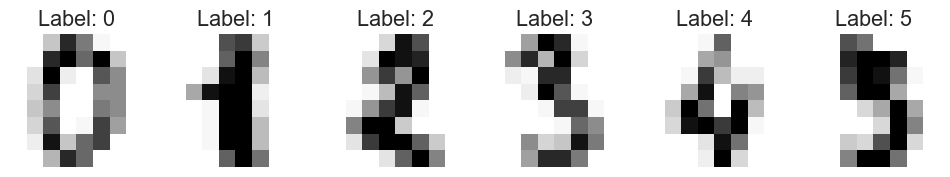

In [250]:
plt.figure(figsize=(12, 10))
for index, (image, target) in enumerate(list(zip(images, targets))[:6]):
    plt.subplot(2, 6, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap='Greys')
    plt.title(f'Label: {target}')

In [251]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler

torch.manual_seed(1234)

In [252]:
class ImageDetection(nn.Module):
    def __init__(self, N_INPUT: int, N_OUTPUT: int):
        super(ImageDetection, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(N_INPUT, 32),  # Warstwa wejściowa z 32 neuronami
            nn.ReLU(),              # Funkcja aktywacji
            nn.Linear(32, 64),      # Warstwa ukryta z 64 neuronami
            nn.Tanh(),              # Funkcja aktywacji
            nn.Linear(64, N_OUTPUT) # Warstwa wyjściowa
        )

    def forward(self, x):
        return self.layers(x)

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            predictions = self.forward(x)
        return torch.argmax(predictions, dim=1)

In [253]:
X_train, X_test, y_train, y_test = train_test_split(images, targets, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

print(f'X_train tensor shape: {X_train_tensor.shape}')
print(f'X_test tensor shape: {X_test_tensor.shape}')
print(f'y_train tensor shape: {y_train_tensor.shape}')
print(f'y_test tensor shape: {y_test_tensor.shape}')

N_INPUT = X_train_tensor.shape[1] 
N_OUTPUT = 10                     
model = ImageDetection(N_INPUT, N_OUTPUT)

X_train tensor shape: torch.Size([1437, 64])
X_test tensor shape: torch.Size([360, 64])
y_train tensor shape: torch.Size([1437])
y_test tensor shape: torch.Size([360])


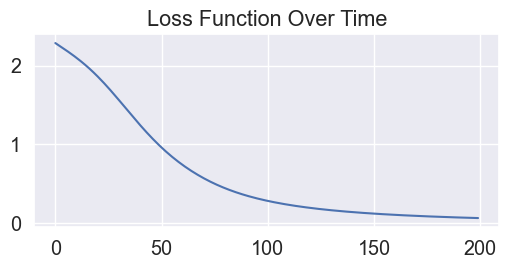

In [254]:
learning_rate = 0.001
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
losses = []

def callback(model, loss):
    losses.append(loss.item())
    clear_output(wait=True)

    plt.figure(figsize=(6, 2.5))
    plt.title('Loss Function Over Time')
    plt.plot(losses)
    plt.show()

def train(X, Y, model, optimiser, epochs, lossfn, callback=None):
    for epoch in range(epochs):
        model.train()
        prediction = model(X)
        loss = lossfn(prediction, Y)

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        model.eval()
        if callback is not None:
            callback(model, loss)

train(X_train_tensor, y_train_tensor, model, optimiser, epochs=200, lossfn=criterion, callback=callback)

In [255]:
y_pred = model.predict(X_test_tensor)
accuracy = (y_pred == y_test_tensor).sum().item() / len(y_test_tensor)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 97.22%


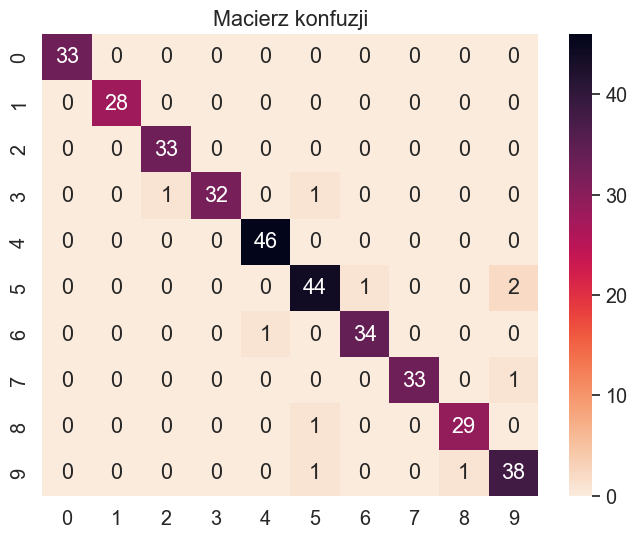

In [256]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.title('Macierz konfuzji')
_ = sns.heatmap(cm, annot=True, cmap=sns.cm.rocket_r)

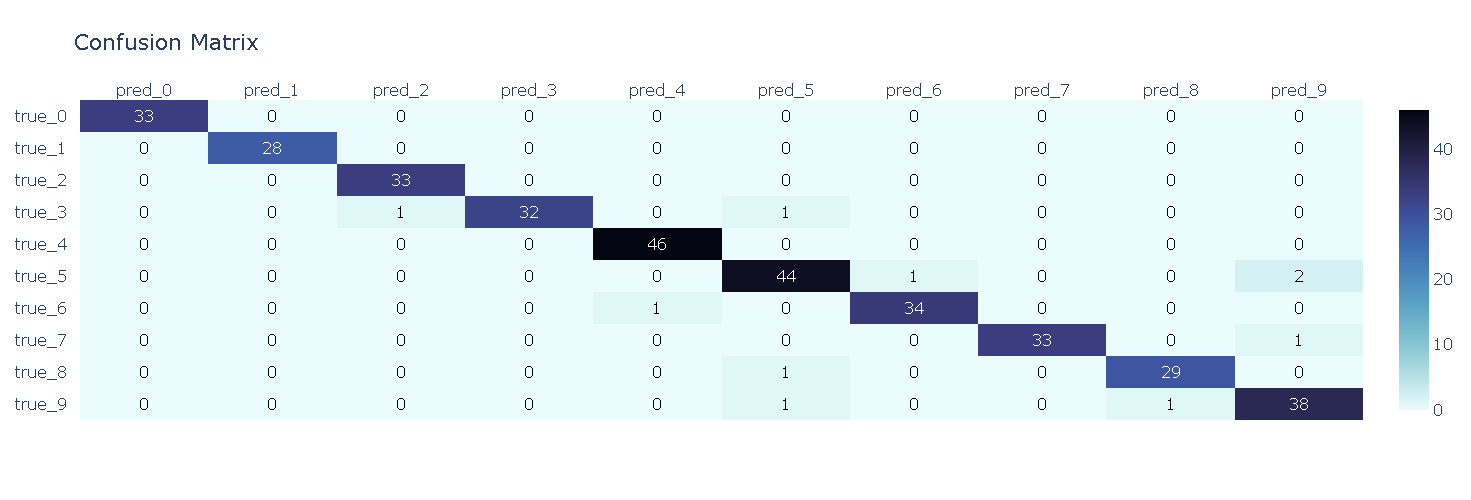

In [257]:
columns = ['pred_' + str(i) for i in range(10)]
index = ['true_' + str(i) for i in range(10)]

def plot_confusion_matrix(cm):
    # Mulitclass classification, 3 classes
    cm = cm[::-1]
    cm = pd.DataFrame(cm, columns=columns, index=index[::-1])

    fig = ff.create_annotated_heatmap(z=cm.values, x=list(cm.columns), y=list(cm.index), 
                                      colorscale='ice', showscale=True, reversescale=True)
    fig.update_layout(width=700, height=500, title='Confusion Matrix', font_size=16)
    fig.show()

plot_confusion_matrix(cm)

In [258]:
results = pd.DataFrame(data={'y_pred': y_pred, 'y_test': y_test})
errors = results[results['y_pred'] != results['y_test']]
errors_idxs = list(errors.index)

Text(0.5, 1.0, 'True 3 Prediction: 2')

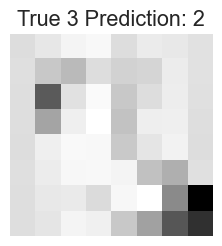

In [259]:
plt.figure(figsize=(12, 10))
for idx, error_idx in enumerate(errors_idxs[:4]):
    image = X_test[error_idx].reshape(8, 8)
plt.subplot(2, 4, idx + 1)
plt.axis('off')
plt.imshow(image, cmap='Greys')
plt.title(f"True {results.loc[error_idx, 'y_test']} Prediction: {results.loc[error_idx, 'y_pred']}")

### Quantum approach

In [287]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import array_to_latex, plot_histogram
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

In [305]:
class QN(nn.Module):
    '''Classical -> Quantum -> Classical'''

    def __init__(self, N_INPUT: int, N_OUTPUT: int, Q_NODE, N_QUBITS):
        super(QN, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(N_INPUT, N_QUBITS),  # Warstwa wejściowa klasyczna
            Q_NODE,                        # Warstwa kwantowa
            nn.Linear(N_QUBITS, 32),  # Warstwa wejściowa z 32 neuronami
            nn.ReLU(),              # Funkcja aktywacji
            nn.Linear(32, 64),      # Warstwa ukryta z 64 neuronami
            nn.Tanh(),              # Funkcja aktywacji
            nn.Linear(64, 64), # Warstwa wyjściowa
            nn.ReLU(),                     # Funkcja aktywacji ReLU
            nn.Linear(64, N_OUTPUT)
        )

    def forward(self, x):
        return self.layers(x)

    def predict(self, x):
        self.eval()  # Ustawienie modelu w tryb ewaluacji
        with torch.no_grad():
            predictions = self.forward(x)  # Przewidywania modelu
        return torch.argmax(predictions, dim=1)  # Zwrócenie klasy o najwyższym prawdopodobieństwie

In [306]:
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

n_layers = 5
weight_shapes = {"weights": (n_layers, n_qubits)}
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

In [307]:
digits = load_digits()
images = digits['images']
targets = digits['target']

X_train, X_test, y_train, y_test = train_test_split(images, targets, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # Dla CrossEntropyLoss typ `long`
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

print(f'X_train tensor shape: {X_train_tensor.shape}')
print(f'X_test tensor shape: {X_test_tensor.shape}')
print(f'y_train tensor shape: {y_train_tensor.shape}')
print(f'y_test tensor shape: {y_test_tensor.shape}')

X_train tensor shape: torch.Size([1437, 64])
X_test tensor shape: torch.Size([360, 64])
y_train tensor shape: torch.Size([1437])
y_test tensor shape: torch.Size([360])


In [308]:
N_INPUT = X_train_tensor.shape[1]
N_OUTPUT = 10
model = QN(N_INPUT=64, N_OUTPUT=10, Q_NODE=qlayer, N_QUBITS=n_qubits)

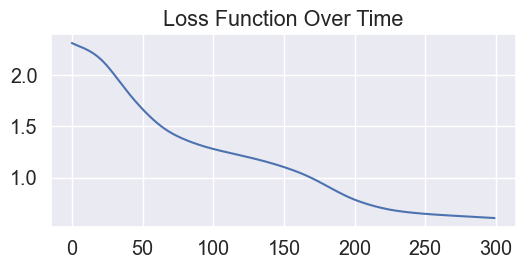

Epoch [299/300], Loss: 0.6074


In [309]:
learning_rate = 0.001
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
losses = []

def callback(model, loss):
    losses.append(loss.item())
    clear_output(wait=True)

    plt.figure(figsize=(6, 2.5))
    plt.title('Loss Function Over Time')
    plt.plot(losses)
    plt.show()

def train(X, Y, model, optimiser, epochs, lossfn, callback=None):
    for epoch in range(epochs):
        model.train()
        prediction = model(X)
        loss = lossfn(prediction, Y)

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        model.eval()
        if callback is not None:
            callback(model, loss)
        
        # Debug: Wydrukuj funkcję straty na każdym kroku
        print(f"Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}")

train(X_train_tensor, y_train_tensor, model, optimiser, epochs=300, lossfn=criterion, callback=callback)

In [312]:
y_pred = model.predict(X_test_tensor)
accuracy = (y_pred == y_test_tensor).sum().item() / len(y_test_tensor)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 72.78%


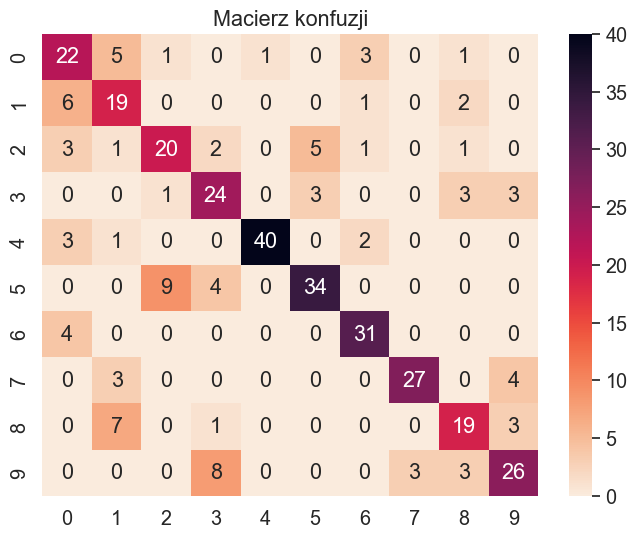

In [313]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.title('Macierz konfuzji')
_ = sns.heatmap(cm, annot=True, cmap=sns.cm.rocket_r)

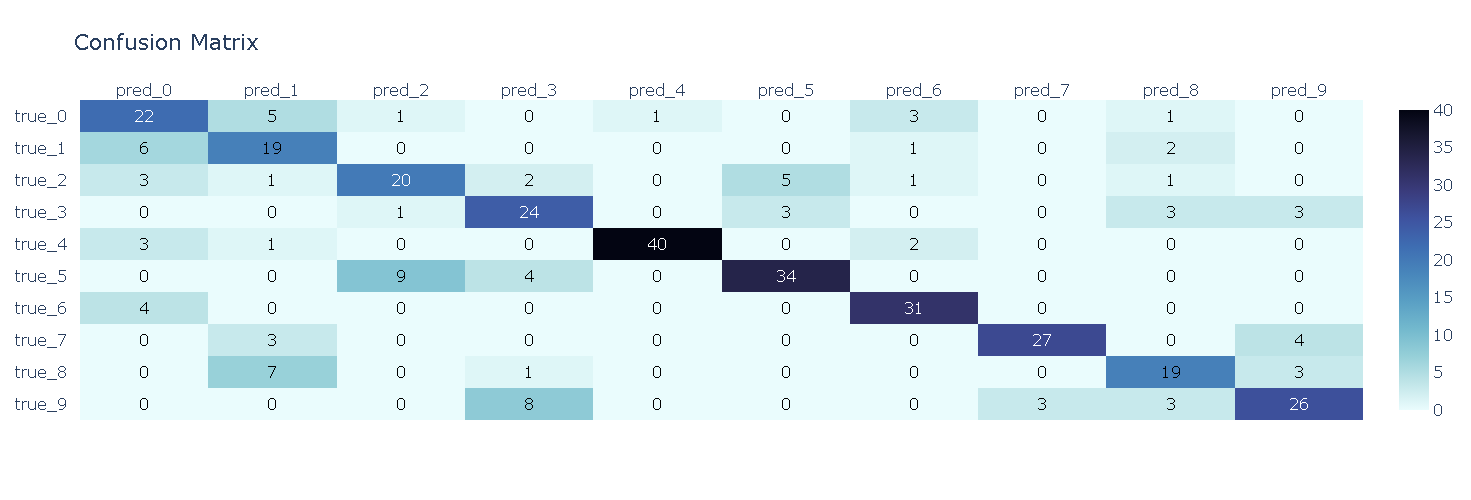

In [314]:
columns = ['pred_' + str(i) for i in range(10)]
index = ['true_' + str(i) for i in range(10)]

def plot_confusion_matrix(cm):
    # Mulitclass classification, 3 classes
    cm = cm[::-1]
    cm = pd.DataFrame(cm, columns=columns, index=index[::-1])

    fig = ff.create_annotated_heatmap(z=cm.values, x=list(cm.columns), y=list(cm.index), 
                                      colorscale='ice', showscale=True, reversescale=True)
    fig.update_layout(width=700, height=500, title='Confusion Matrix', font_size=16)
    fig.show()

plot_confusion_matrix(cm)

In [315]:
results = pd.DataFrame(data={'y_pred': y_pred, 'y_test': y_test})
errors = results[results['y_pred'] != results['y_test']]
errors_idxs = list(errors.index)

Text(0.5, 1.0, 'True 8 Prediction: 1')

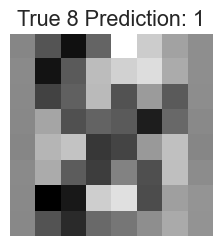

In [316]:
plt.figure(figsize=(12, 10))
for idx, error_idx in enumerate(errors_idxs[:4]):
    image = X_test[error_idx].reshape(8, 8)
plt.subplot(2, 4, idx + 1)
plt.axis('off')
plt.imshow(image, cmap='Greys')
plt.title(f"True {results.loc[error_idx, 'y_test']} Prediction: {results.loc[error_idx, 'y_pred']}")